# BIAS ANALYSIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

In [2]:
periods = ['Q1', 'Q2', 'Q3', 'A1', 'A2']

In [3]:
data = {}
for period in periods:
    data[period] = pd.read_csv(f"results/{period}_rf.csv")

NOTE: 

We trim the data at the 1% level each period before taking the average. divide annual by 4

Text(0.5, 1.0, 'Average bias of analysts earings expectations relative to machine learning forecasts')

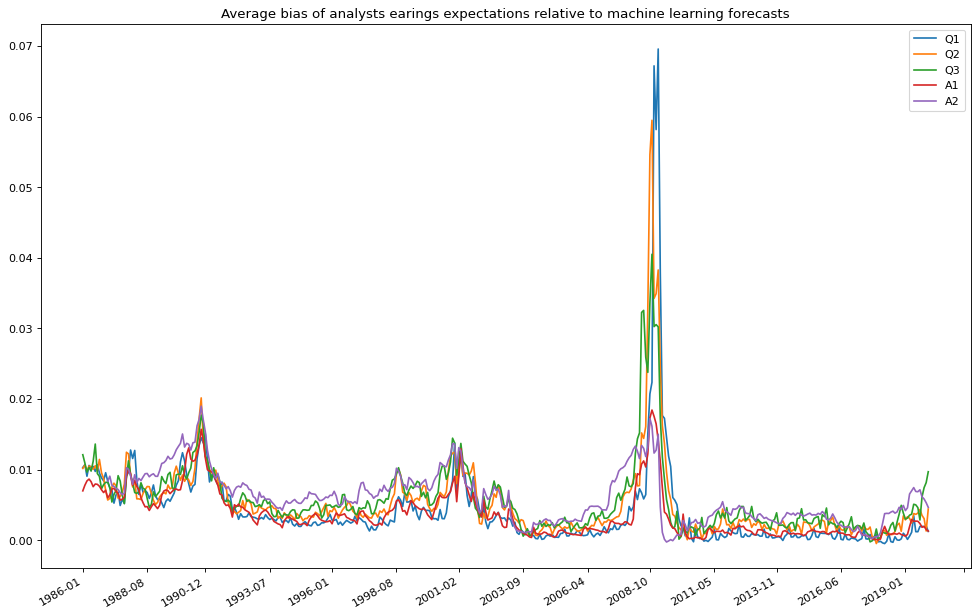

In [7]:
plt.figure(figsize=(15, 10), dpi=80)
for period, df in data.items():
    if period == 'A2' or period=='A1':
        df.biased_expectation = df.biased_expectation/4
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).biased_expectation.apply(lambda x: stats.trim_mean(x, 0.01)), label=period);
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.legend()   
plt.title('Average bias of analysts earings expectations relative to machine learning forecasts') 

Text(0.5, 1.0, 'Average realized bias of analysts earings expectations')

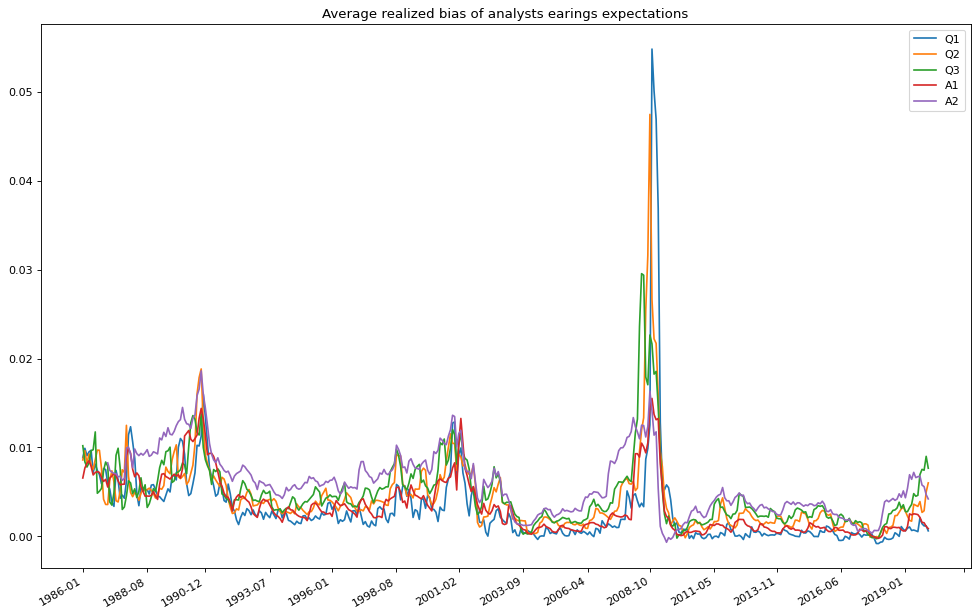

In [9]:
plt.figure(figsize=(15, 10), dpi=80)
for period, df in data.items():
    df['bias_analyst_actual'] = (df.adj_meanest - df.adj_actual) / df.price
    if period == 'A2' or period=='A1':
        df.bias_analyst_actual = df.bias_analyst_actual / 4
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=period);
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.legend()  
plt.title('Average realized bias of analysts earings expectations') 


In [6]:
def compute_bias_results ( period):
    df = data[period]
    RF = df.predicted_adj_actual.mean()
    AF = df.adj_meanest.mean()
    AE = df.adj_actual.mean()
    RF_AE = (df.predicted_adj_actual - df.adj_actual).mean()
    AF_AE = (df.adj_meanest - df.adj_actual).mean()
    RF_AE2 = ((df.predicted_adj_actual - df.adj_actual)**2).mean()
    AF_AE2 = ((df.adj_meanest - df.adj_actual)**2).mean()
    bias = ((df.adj_meanest - df.predicted_adj_actual) / df.price).mean()

    return {'value': period,'RF': round(RF, 3), 'AF': round(AF, 3), 'AE':round(AE, 3),'(RF-AE)':round(RF_AE, 3), '(AF-AE)':round(AF_AE, 3),
    '(RF-AE)^2':round(RF_AE2, 3), '(AF-AE)^2': round(AF_AE2, 3), '(AF-RF)/P':round(bias, 3), 'N':len(df) }
    

In [7]:
# Create an empty dictionary to store DataFrames
results = []

for period in periods:
    results.append(compute_bias_results(period))

In [8]:
display(pd.DataFrame(results).set_index('value').rename_axis(None))

,RF,AF,AE,(RF-AE),(AF-AE),(RF-AE)^2,(AF-AE)^2,(AF-RF)/P,N
Q1,0.257,0.277,0.258,-0.001,0.020,0.092,0.170,0.006,914102
Q2,0.272,0.318,0.272,0.000,0.046,0.101,0.147,0.006,830178
Q3,0.287,0.351,0.287,0.000,0.064,0.111,0.204,0.006,761818
A1,0.943,1.063,0.943,-0.000,0.120,0.172,0.581,0.021,958250
A2,1.059,1.396,1.060,-0.001,0.336,0.160,1.782,0.027,801748


In [9]:
df = data['A1']
t, p = stats.ttest_1samp(df.predicted_adj_actual -  df.adj_actual, 0, alternative='two-sided')
print(f't-test is {t}')
print(f'p-value is {p}')

t-test is -0.009810546623635216
p-value is 0.9921724439213846


In [10]:
df = data['Q3']
df['RF_AE'] = (df.adj_meanest - df.predicted_adj_actual) 
model = sm.OLS( exog = np.ones(len(df)), endog = df.RF_AE).fit()
new = model.get_robustcov_results(cov_type='HAC',maxlags=3)
T_test = new.t_test([1]) 
print(T_test)



                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0639      0.000    145.435      0.000       0.063       0.065


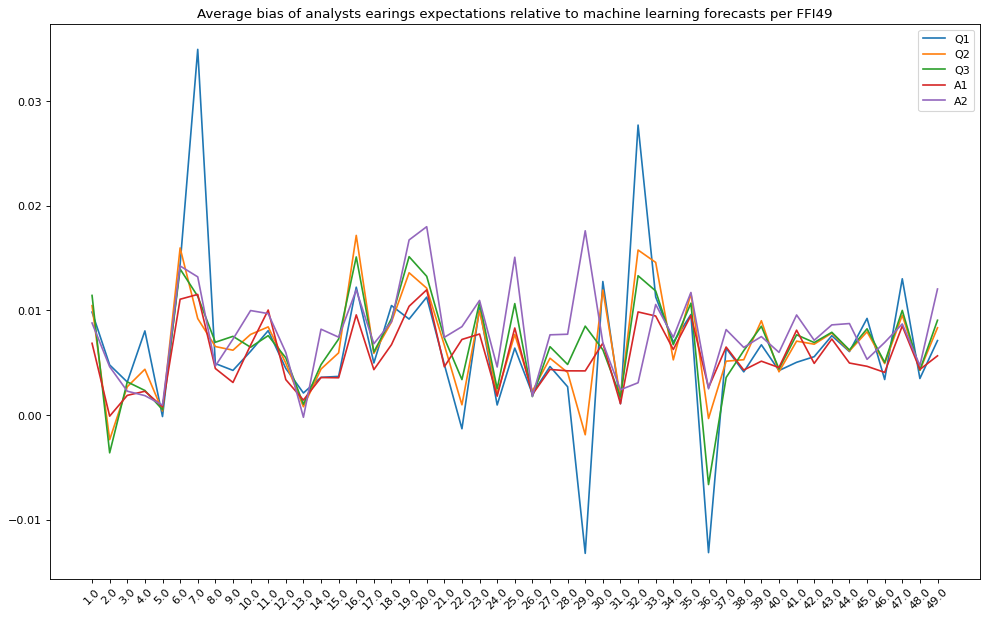

In [11]:
plt.figure(figsize=(15, 9), dpi=80)
for period in periods: 
    df = data[period].copy()
    df.sort_values('ffi49', inplace=True)
    #if period == 'A2' or period=='A1':
       # df.biased_expectation = df.biased_expectation / 4
    plt.plot(df.ffi49.unique().astype(str), df.groupby(['ffi49']).biased_expectation.apply(lambda x: x.mean()), label=period);  #stats.trim_mean(x, 0.01)
    plt.xticks(rotation=45)
    plt.legend()   
    plt.title('Average bias of analysts earings expectations relative to machine learning forecasts per FFI49') 

## Bias and Number of Anlysts

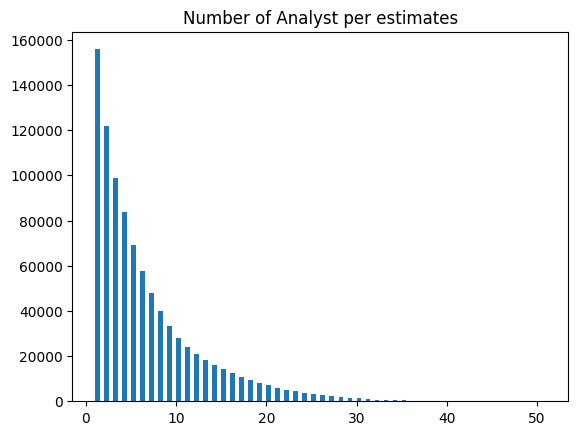

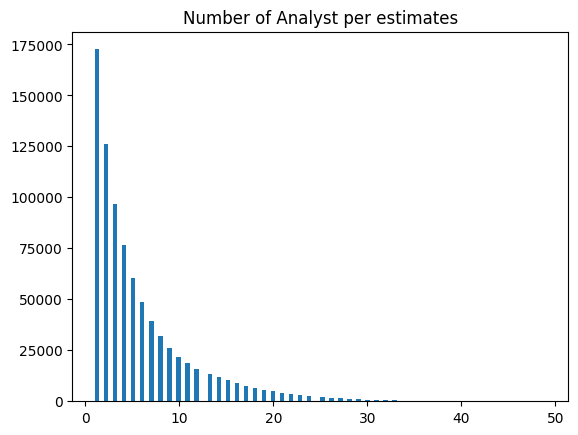

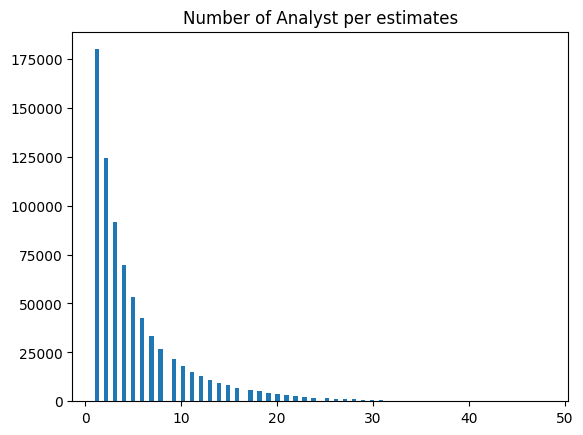

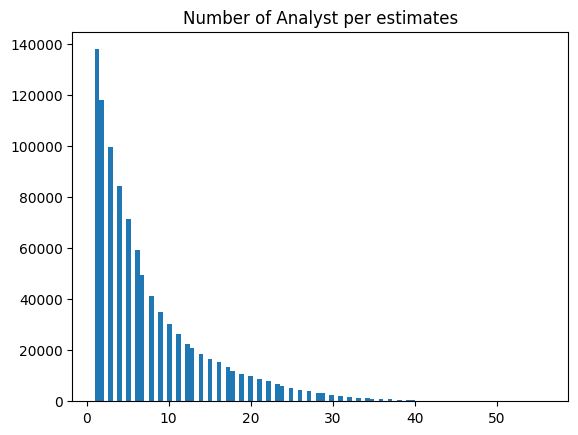

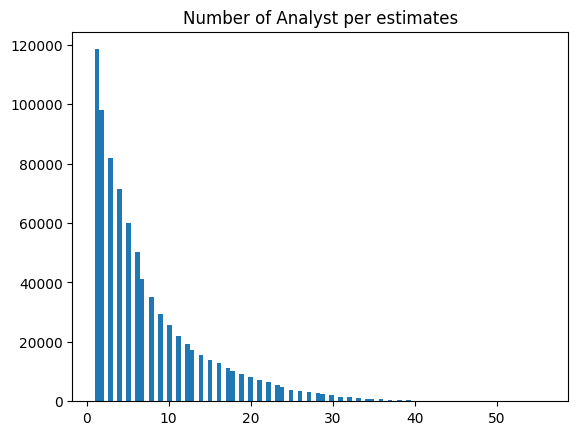

In [12]:
for period in periods: 
    plt.figure()
    df = data[period].copy()
    plt.hist(df.numest, bins=100)
    plt.title('Number of Analyst per estimates') 

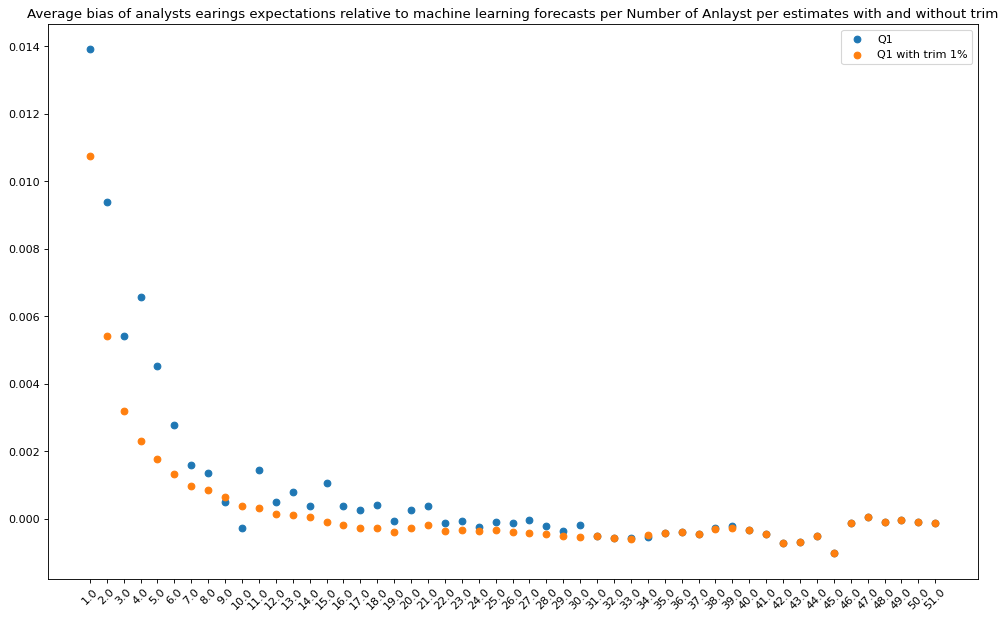

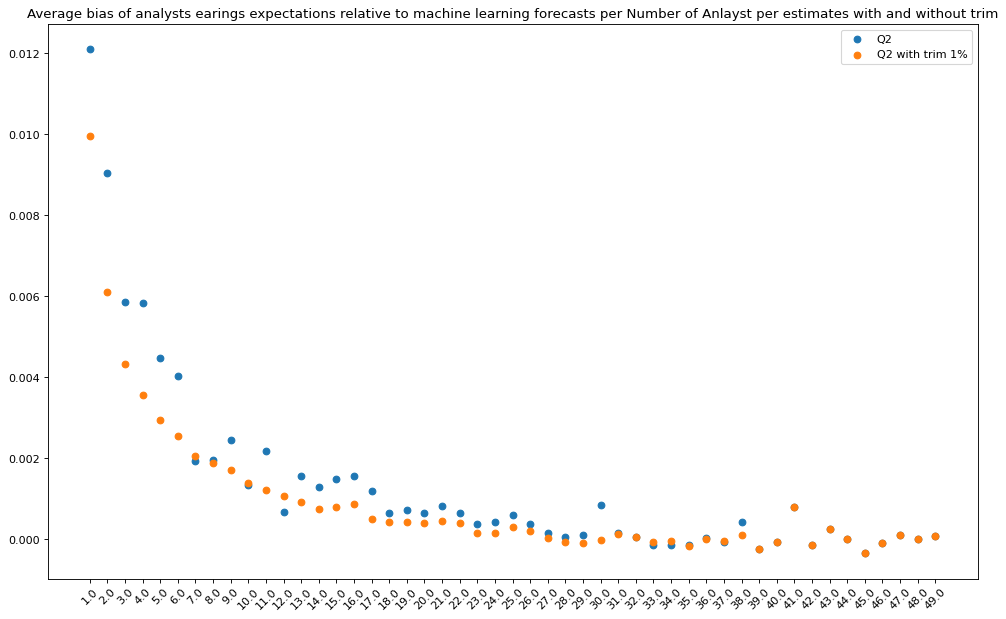

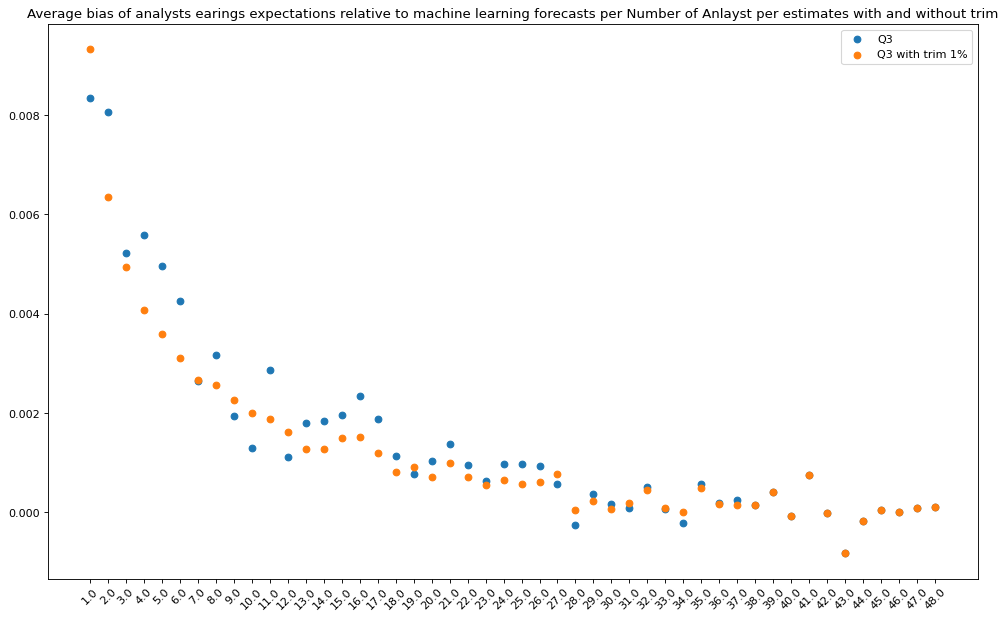

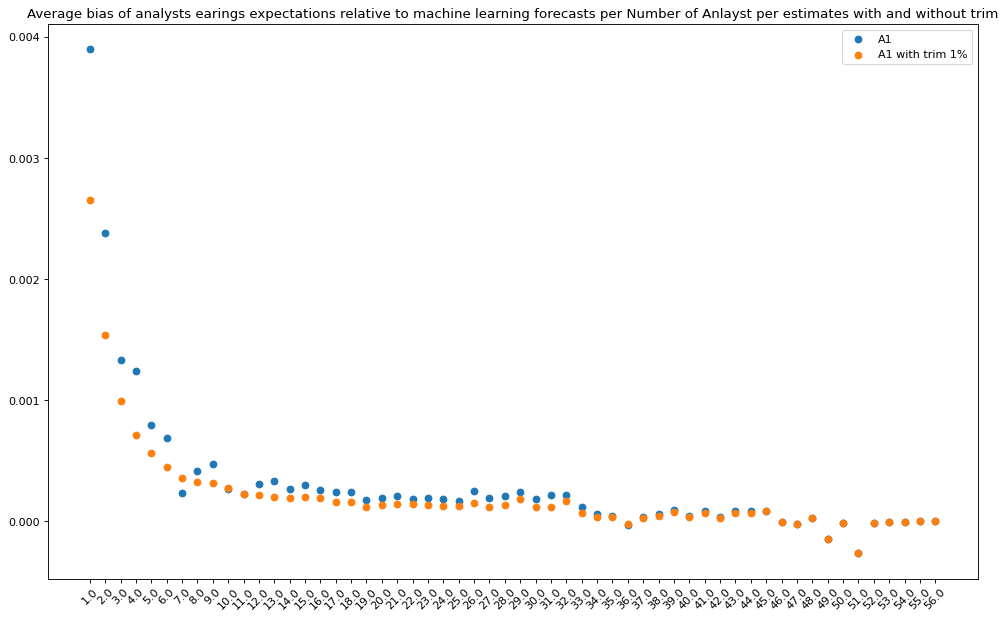

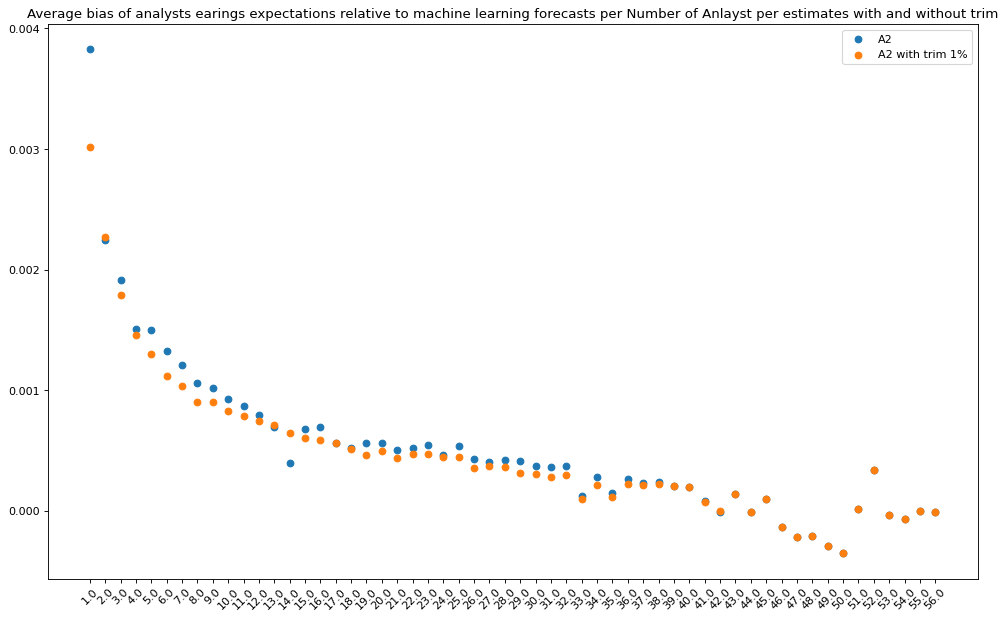

In [13]:
for period in periods: 
    plt.figure(figsize=(15, 9), dpi=80)
    df = data[period].copy()
    df.sort_values('numest', inplace=True)
    if period == 'A2' or period=='A1':
        df.biased_expectation = df.biased_expectation / 4
    plt.scatter( df.numest.unique().astype(str), df.groupby(['numest']).biased_expectation.apply(lambda x: x.mean()), label=f'{period}'); #stats.trim_mean(x, 0.01)
    plt.scatter( df.numest.unique().astype(str), df.groupby(['numest']).biased_expectation.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period} with trim 1%'); 
    plt.xticks(rotation=45)
    plt.legend()   
    plt.title('Average bias of analysts earings expectations relative to machine learning forecasts per Number of Anlayst per estimates with and without trim') 

#### We redo the bias timeseries analysis but consideirng differnet bis wrt to the number of analysts that build the forecast
#### Note: we focus on A1 and A2 forecats horizons

In [17]:
df_1 = pd.read_csv(f"results/A1_rf.csv")
df_2 = pd.read_csv(f"results/A2_rf.csv")
dictionary = {'A1': df_1, 'A2': df_2}

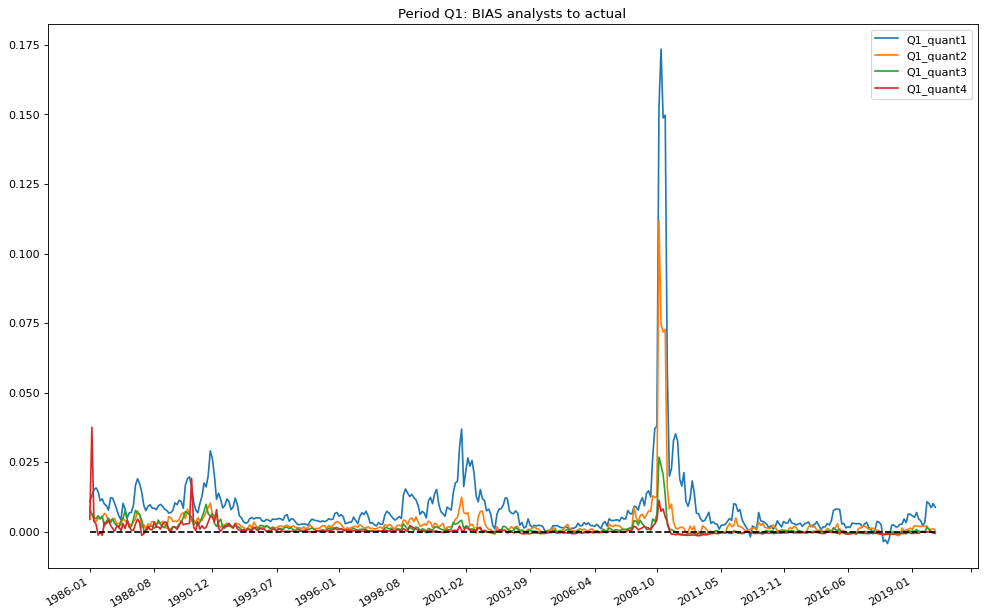

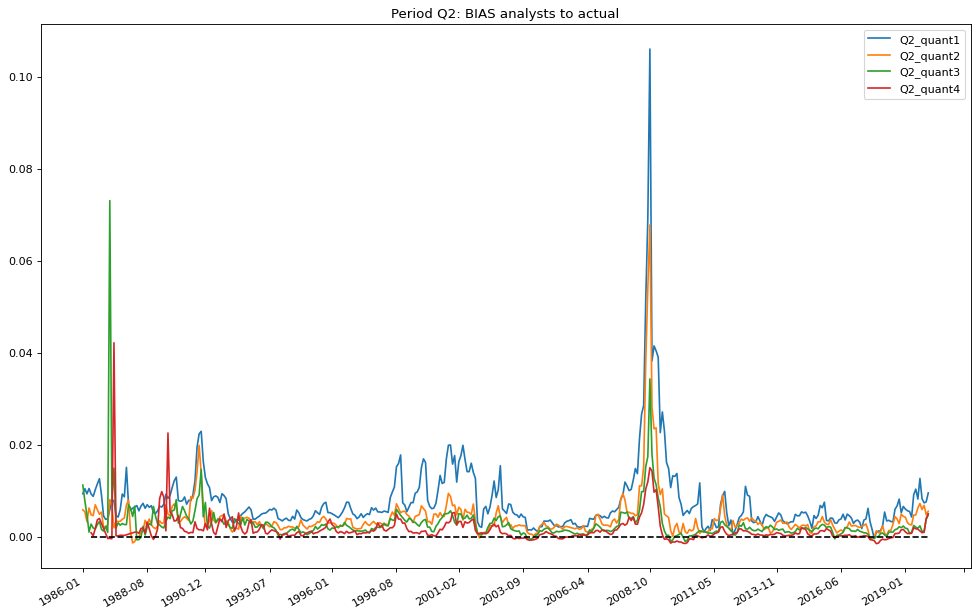

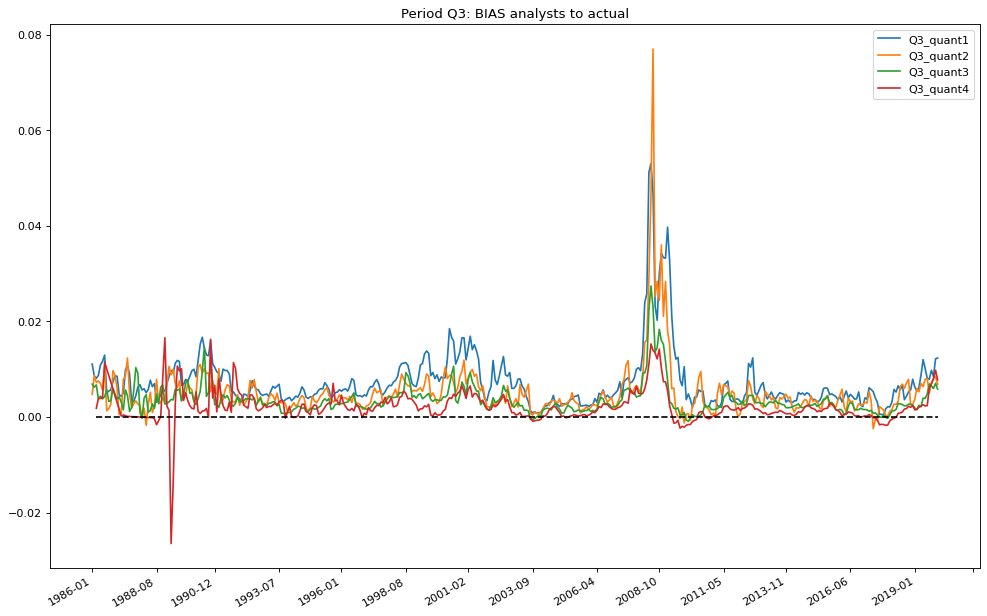

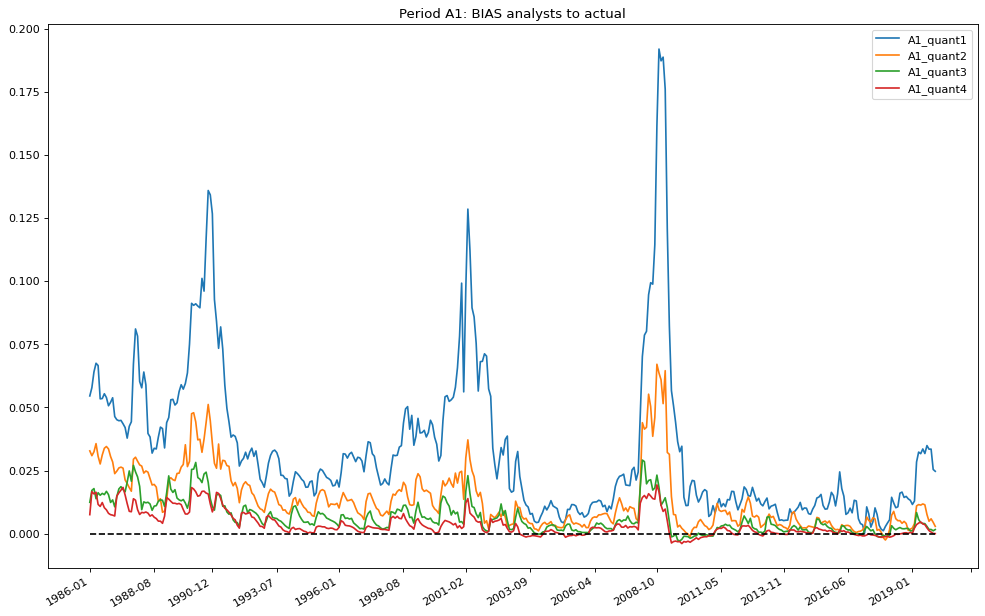

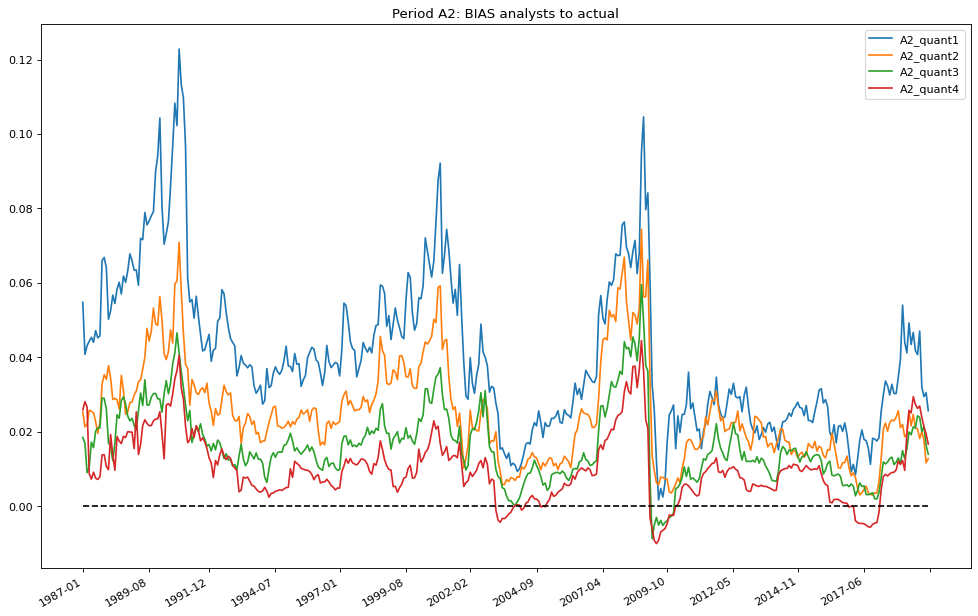

In [14]:
for period, df in data.items():
    plt.figure(figsize=(15, 10), dpi=80)
    df['bias_analyst_actual'] = (df.adj_meanest - df.adj_actual) / df.price
    df_trunc = df[df.numest <= df.numest.quantile(0.25)]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant1');
    df_trunc = df[(df.numest > df.numest.quantile(0.25)) & (df.numest <= df.numest.quantile(0.5)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant2');
    df_trunc = df[(df.numest > df.numest.quantile(0.5)) & (df.numest <= df.numest.quantile(0.75)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant3');
    df_trunc = df[(df.numest > df.numest.quantile(0.75)) & (df.numest <= df.numest.quantile(1)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant4');
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df_trunc.Date.unique().astype(str)), max(df_trunc.Date.unique().astype(str)), 'black', linestyles='dashed')
    plt.legend()   
    plt.title(f'Period {period}: BIAS analysts to actual') 

/var/folders/gf/n_mlnzkx2hq9v2tbywpcl_mm0000gn/T/ipykernel_4862/2335046417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bias_analyst_actual'] = (df.adj_meanest - df.adj_actual) / df.price
/var/folders/gf/n_mlnzkx2hq9v2tbywpcl_mm0000gn/T/ipykernel_4862/2335046417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bias_analyst_actual'] = (df.adj_meanest - df.adj_actual) / df.price
/var/folders/gf/n_mlnzkx2hq9v2tbywpcl_mm0000gn/T/ipykernel_4862/2335046417.py:4: SettingWithCopyWarning: 
A value 

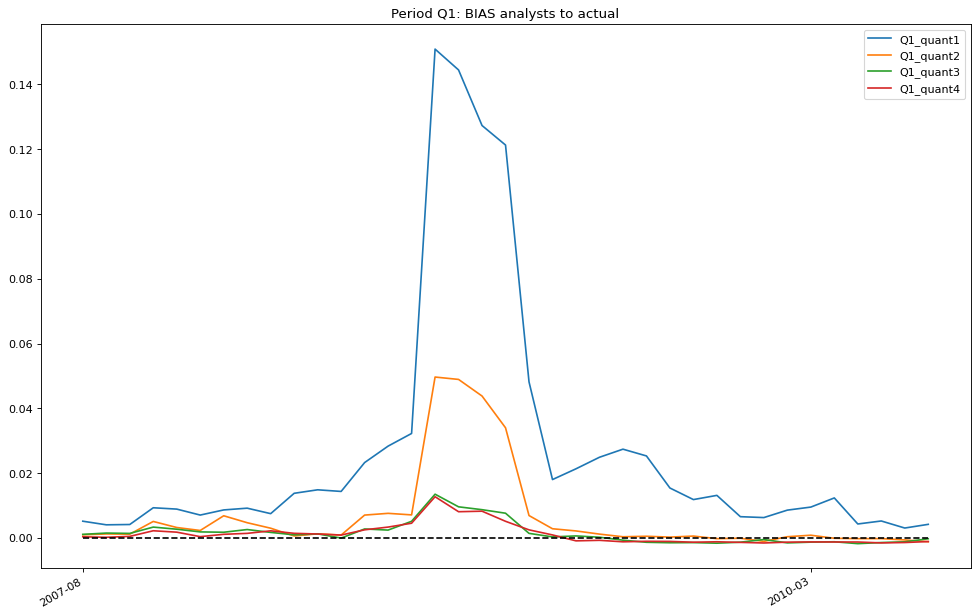

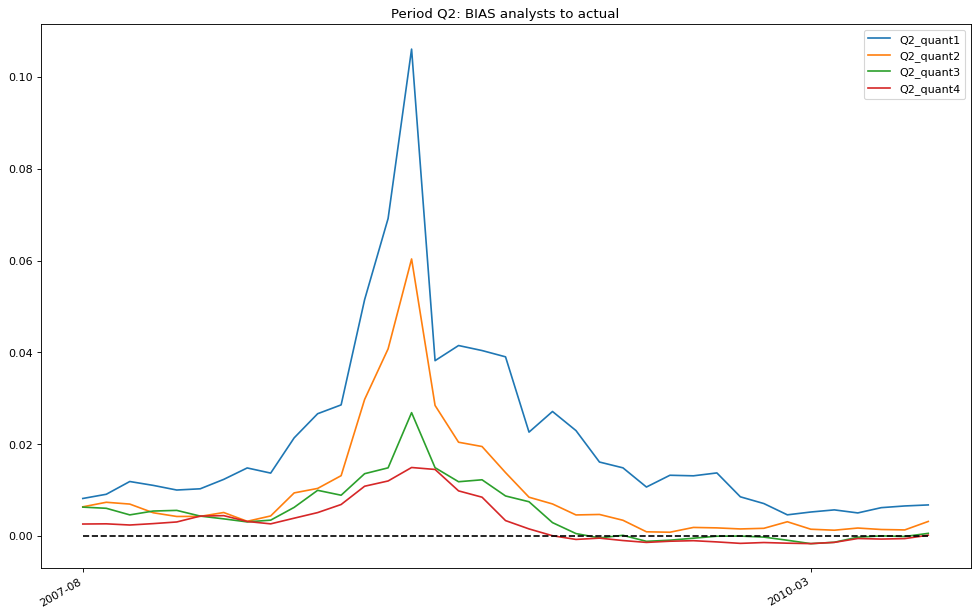

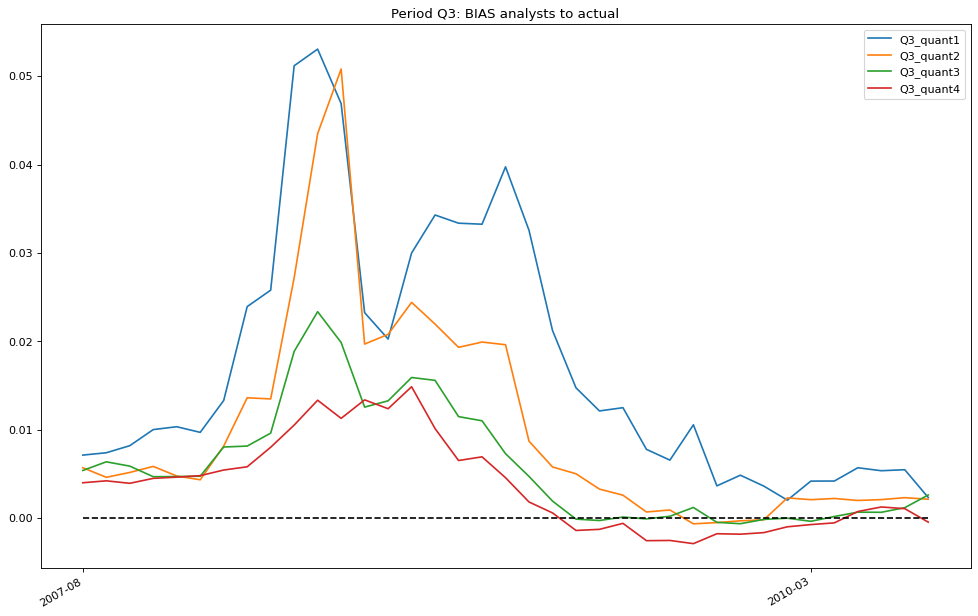

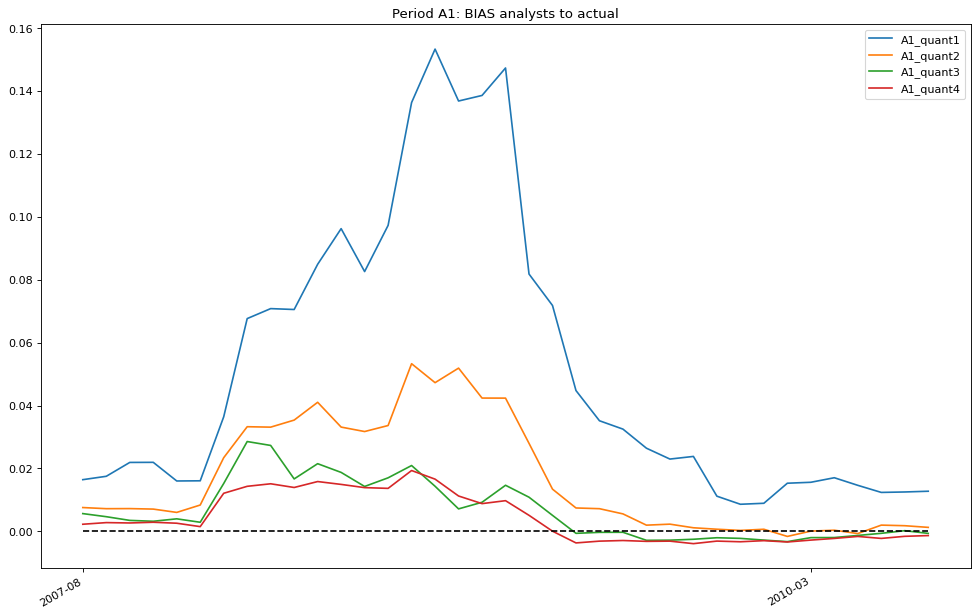

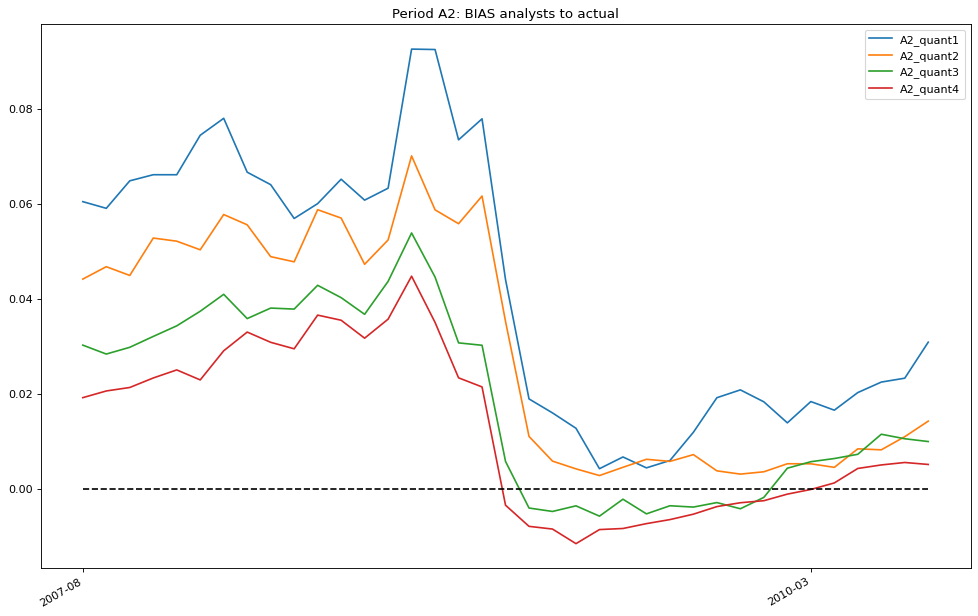

In [15]:
for period, df in data.items():
    plt.figure(figsize=(15, 10), dpi=80)
    df = df[(df.Date>='2007-08') & (df.Date<='2010-08')]
    df['bias_analyst_actual'] = (df.adj_meanest - df.adj_actual) / df.price
    df_trunc = df[df.numest <= df.numest.quantile(0.25)]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant1');
    df_trunc = df[(df.numest > df.numest.quantile(0.25)) & (df.numest <= df.numest.quantile(0.5)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant2');
    df_trunc = df[(df.numest > df.numest.quantile(0.5)) & (df.numest <= df.numest.quantile(0.75)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant3');
    df_trunc = df[(df.numest > df.numest.quantile(0.75)) & (df.numest <= df.numest.quantile(1)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant4');
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df_trunc.Date.unique().astype(str)), max(df_trunc.Date.unique().astype(str)), 'black', linestyles='dashed')
    plt.legend()   
    plt.title(f'Period {period}: BIAS analysts to actual') 

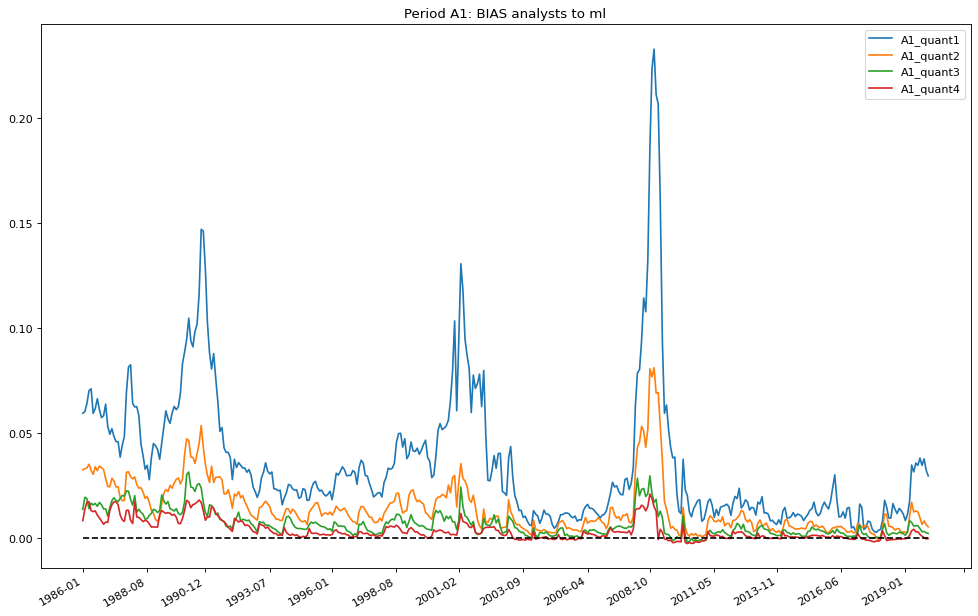

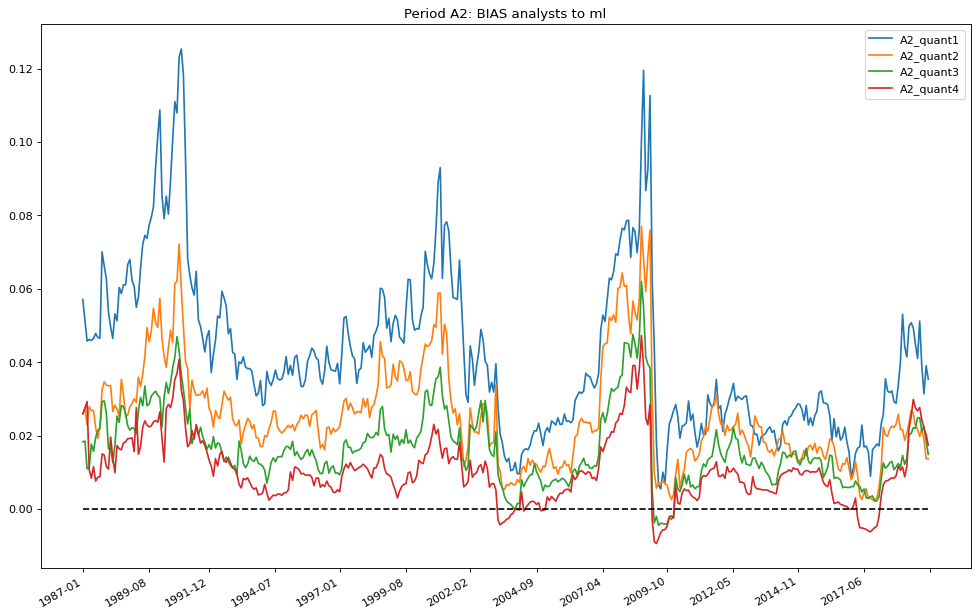

In [16]:
for period, df in dictionary.items():
    plt.figure(figsize=(15, 10), dpi=80)
    df_trunc = df[df.numest <= df.numest.quantile(0.25)]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).biased_expectation.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant1');
    df_trunc = df[(df.numest > df.numest.quantile(0.25)) & (df.numest <= df.numest.quantile(0.5)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).biased_expectation.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant2');
    df_trunc = df[(df.numest > df.numest.quantile(0.5)) & (df.numest <= df.numest.quantile(0.75)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).biased_expectation.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant3');
    df_trunc = df[(df.numest > df.numest.quantile(0.75)) & (df.numest <= df.numest.quantile(1)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).biased_expectation.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant4');
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df_trunc.Date.unique().astype(str)), max(df_trunc.Date.unique().astype(str)), 'black', linestyles='dashed')
    plt.legend()   
    plt.title(f'Period {period}: BIAS analysts to ml') 

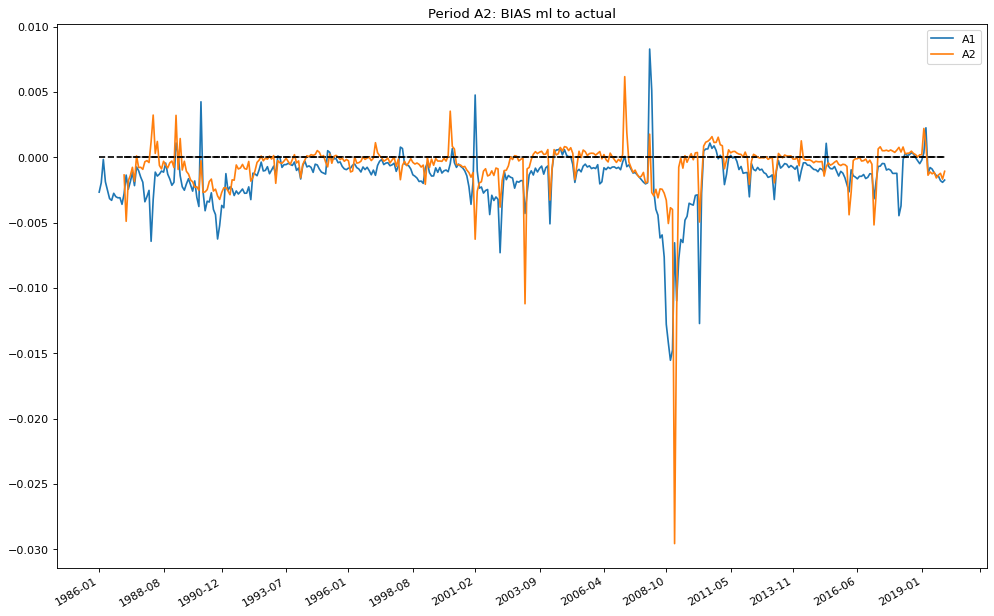

In [17]:
plt.figure(figsize=(15, 10), dpi=80)
for period, df in dictionary.items():
    df['bias_ml_actual'] = (df.predicted_adj_actual - df.adj_actual) / df.price
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).bias_ml_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}');
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df.Date.unique().astype(str)), max(df.Date.unique().astype(str)), 'black', linestyles='dashed')
    plt.legend()   
    plt.title(f'Period {period}: BIAS ml to actual') 

## Regulation nov 2000 - Reg FD

In [18]:
def compute_bias_results ( period):
    df = data[period]
    df_pre = df[df.Date<= '2000-10']
    df_post = df[df.Date>'2000-10']
    bias_analyst_ml_pre = ((df_pre.adj_meanest - df_pre.predicted_adj_actual) / df_pre.price).mean()
    bias_analyst_actual_pre = ((df_pre.adj_meanest - df_pre.adj_actual) / df_pre.price).mean()

    bias_analyst_ml_post = ((df_post.adj_meanest - df_post.predicted_adj_actual) / df_post.price).mean()
    bias_analyst_actual_post = ((df_post.adj_meanest - df_post.adj_actual) / df_post.price).mean()

    return {'value': period, 'bias_analyst_actual_pre':round(bias_analyst_actual_pre, 3), 'bias_analyst_actual_post':round(bias_analyst_actual_post, 3),
     'bias_analyst_ml_pre':round(bias_analyst_ml_pre, 3), 'bias_analyst_ml_post':round(bias_analyst_ml_post, 3),'N pre':len(df_pre), 'N post':len(df_post) }
  

In [19]:
# Create an empty dictionary to store DataFrames
results = []

for period in ['A1', 'A2']:
    results.append(compute_bias_results(period))

In [20]:
display(pd.DataFrame(results).set_index('value').rename_axis(None))

,bias_analyst_actual_pre,bias_analyst_actual_post,bias_analyst_ml_pre,bias_analyst_ml_post,N pre,N post
A1,0.030,0.015,0.029,0.015,418143,540107
A2,0.038,0.019,0.038,0.020,317581,484167


## Bias and Error

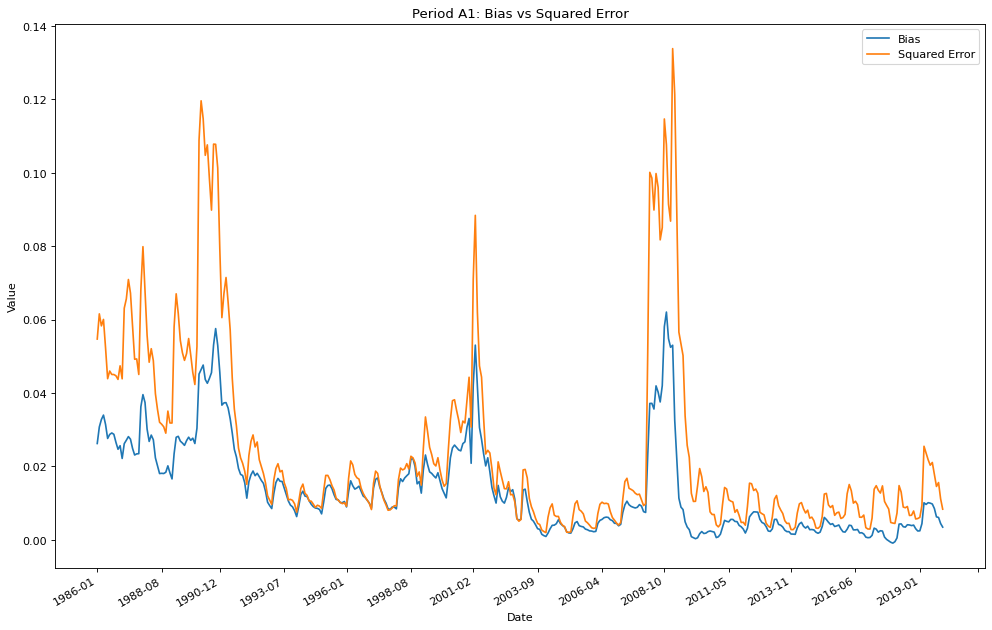

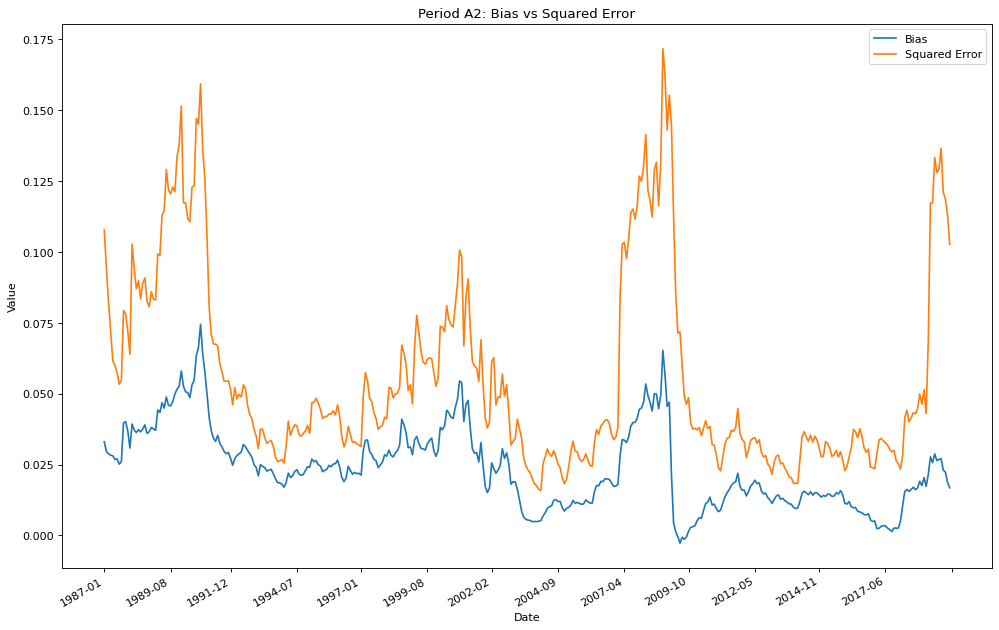

In [21]:

for period, df in dictionary.items():
    plt.figure(figsize=(15, 10), dpi=80)
    
    # Calculate bias
    df['bias_analyst_actual'] = (df['adj_meanest'] - df['adj_actual']) / df['price']
    
    # Calculate squared error
    df['squared_error'] = ((df['adj_meanest'] - df['adj_actual']) ** 2) / df['price']
    
    # Group by date and calculate trimmed mean bias and squared error
    df_grouped = df.groupby('Date').agg({'bias_analyst_actual': lambda x: stats.trim_mean(x, 0.01),
                                         'squared_error': lambda x: stats.trim_mean(x, 0.01)})
    
    # Plot bias against squared error
    plt.plot(df_grouped.index.astype(str), df_grouped['bias_analyst_actual'], label='Bias')
    plt.plot(df_grouped.index.astype(str), df_grouped['squared_error'], label='Squared Error')
    
    # Set x-axis to display months and rotate labels
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    
    # Add legend and title
    plt.legend()
    plt.title(f'Period {period}: Bias vs Squared Error')
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    plt.show()


20 points are 0.0 % data
20 points are 0.0 % data


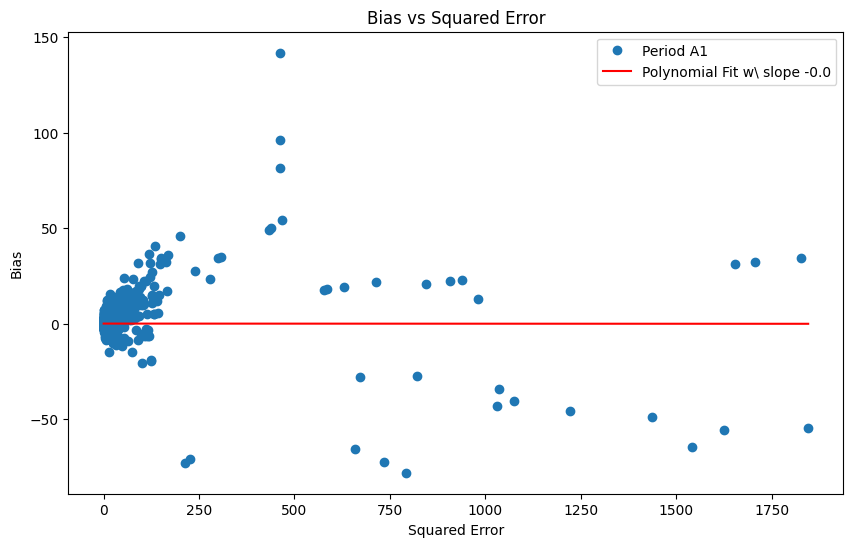

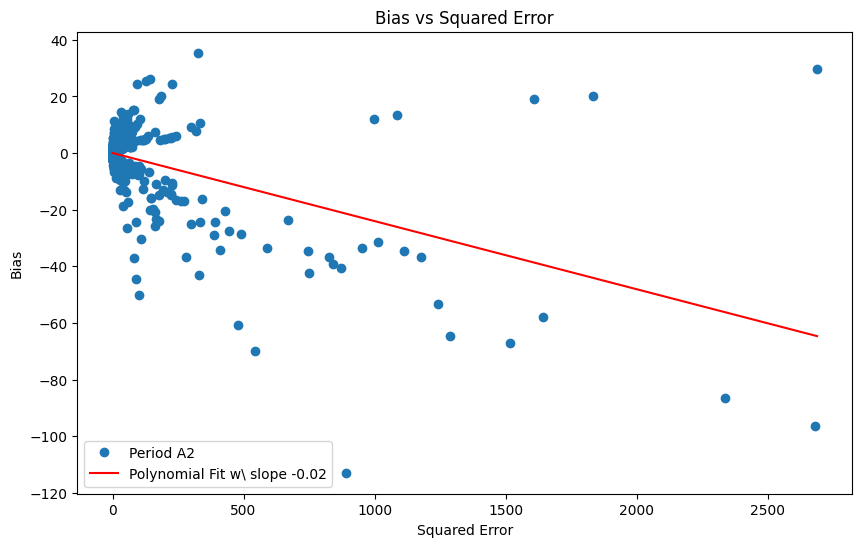

In [22]:
# CASE 1  where evry comapny- every date is a point

for period, df in dictionary.items():
    plt.figure(figsize=(10, 6))
    
    # Calculate bias
    df['bias_analyst_actual'] = (df['adj_meanest'] - df['adj_actual']) / df['price']
    
    # Calculate squared error
    df['squared_error'] = ((df['adj_meanest'] - df['adj_actual']) ** 2) / df['price']

    # Group by date and calculate trimmed mean bias and squared error
    df_grouped = df.copy()

    # Sort DataFrame by squared error
    print(f'20 points are {np.round(20/df_grouped.shape[0]*100, 1)} % data')
    df_sorted = df_grouped.sort_values(by='squared_error')[5:-5]
    
    # Fit a polynomial
    coeffs = np.polyfit(df_sorted['squared_error'], df_sorted['bias_analyst_actual'], 1)
    poly = np.poly1d(coeffs) 
    
    # Plot bias against sorted squared error sequence
    plt.plot(df_sorted['squared_error'], df_sorted['bias_analyst_actual'], 'o', label=f'Period {period}')
    
    # Plot polynomial fit
    plt.plot(df_sorted['squared_error'], poly(df_sorted['squared_error']), label=f'Polynomial Fit w\ slope {np.round(coeffs[0], 2)}', color='red')
    
    # Add legend and labels
    plt.legend()
    plt.title('Bias vs Squared Error')
    plt.xlabel('Squared Error')
    plt.ylabel('Bias')
    
plt.show()


5 points are 1.2 % data
5 points are 1.3 % data


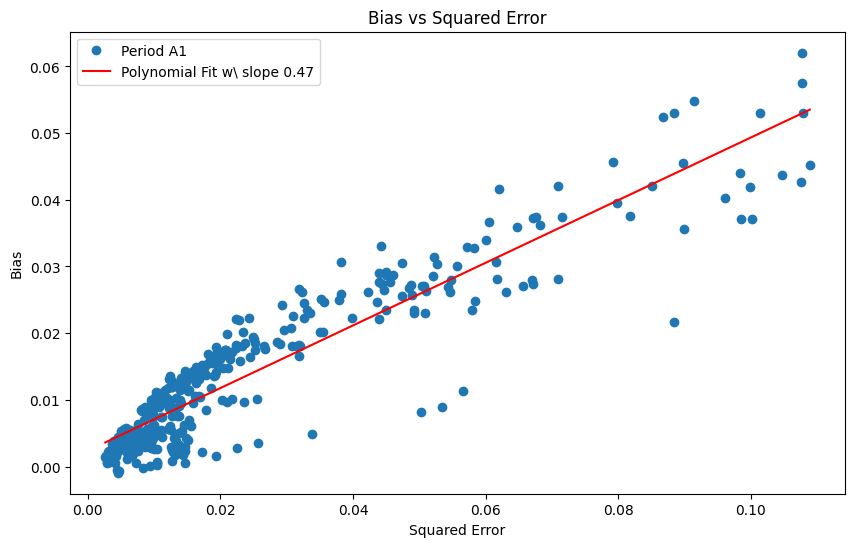

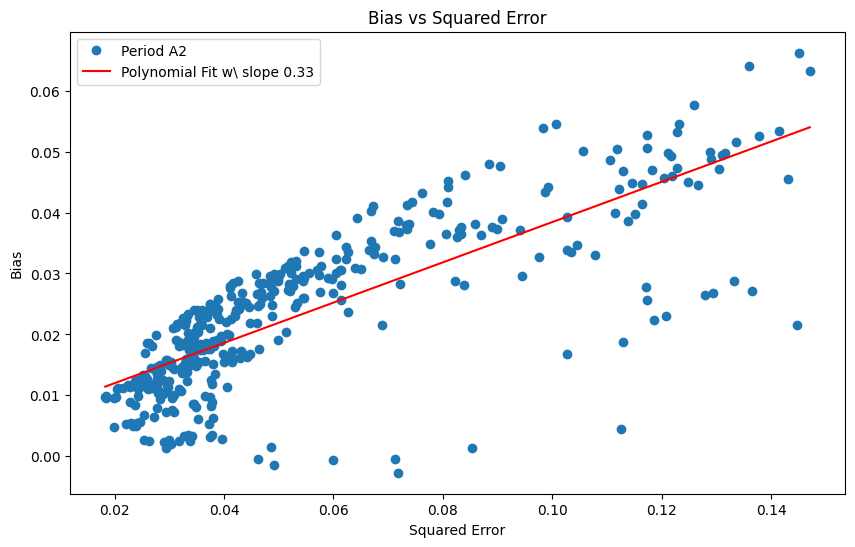

In [20]:
# CASE 2 where we group by date before
for period, df in dictionary.items():
    plt.figure(figsize=(10, 6))
    
    # Calculate bias
    df['bias_analyst_actual'] = (df['adj_meanest'] - df['adj_actual']) / df['price']
    
    # Calculate squared error
    df['squared_error'] = ((df['adj_meanest'] - df['adj_actual']) ** 2) / df['price']

    # Group by date and calculate trimmed mean bias and squared error
    df_grouped = df.groupby('Date').agg({'bias_analyst_actual': lambda x: stats.trim_mean(x, 0.01),
                                         'squared_error': lambda x: stats.trim_mean(x, 0.01)})

    # Sort DataFrame by squared error
    print(f'5 points are {np.round(5/df_grouped.shape[0]*100, 1)} % data')
    df_sorted = df_grouped.sort_values(by='squared_error')[5:-5]
    
    # Fit a polynomial
    coeffs = np.polyfit(df_sorted['squared_error'], df_sorted['bias_analyst_actual'], 1)
    poly = np.poly1d(coeffs) 
    
    # Plot bias against sorted squared error sequence
    plt.plot(df_sorted['squared_error'], df_sorted['bias_analyst_actual'], 'o', label=f'Period {period}')
    
    # Plot polynomial fit
    plt.plot(df_sorted['squared_error'], poly(df_sorted['squared_error']), label=f'Polynomial Fit w\ slope {np.round(coeffs[0], 2)}', color='red')
    
    # Add legend and labels
    plt.legend()
    plt.title('Bias vs Squared Error')
    plt.xlabel('Squared Error')
    plt.ylabel('Bias')
    
plt.show()


5 points are 1.2 % data


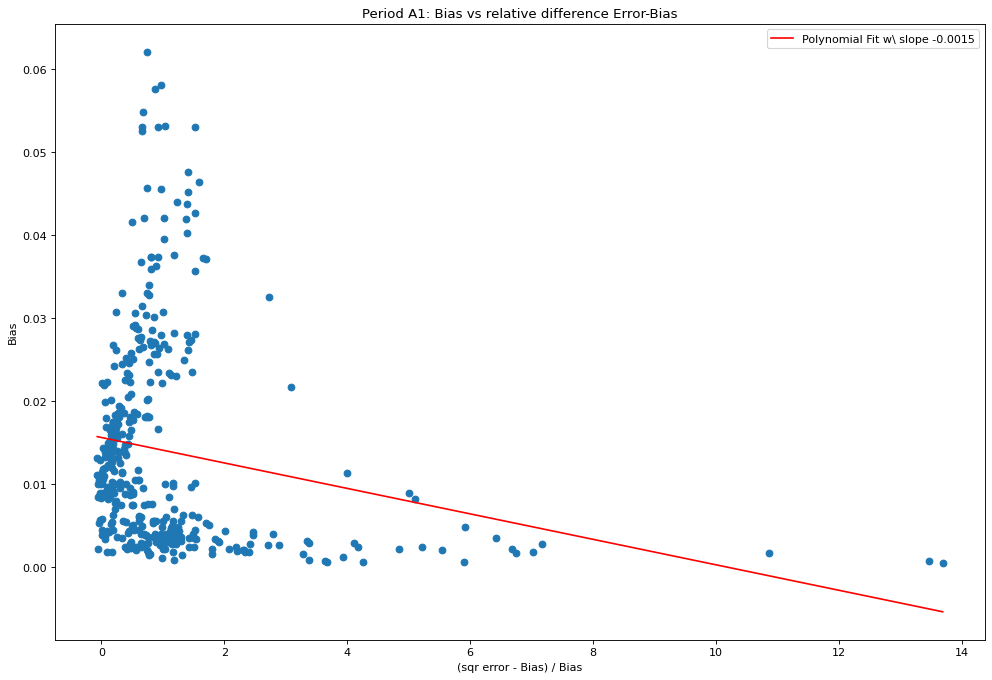

5 points are 1.3 % data


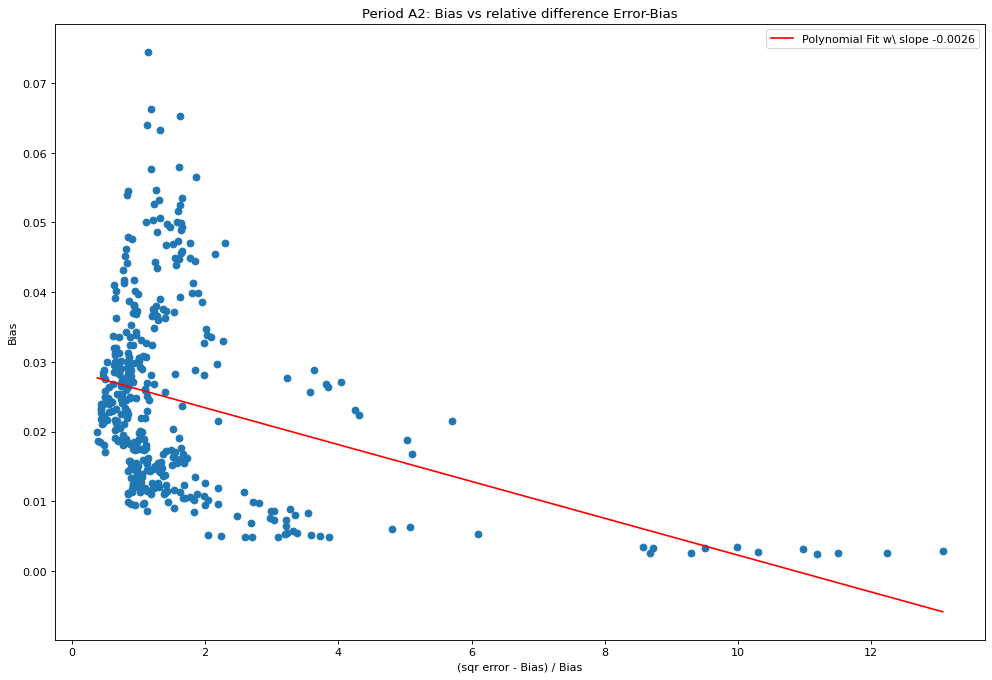

In [24]:
# CASE 3 consider relative measure
for period, df in dictionary.items():
    plt.figure(figsize=(15, 10), dpi=80)
    
    
    # Group by date and calculate trimmed mean bias and squared error
    df_grouped = df.groupby('Date').agg({'bias_analyst_actual': lambda x: stats.trim_mean(x, 0.01),
                                        'squared_error': lambda x: stats.trim_mean(x, 0.01)})
 
    df_grouped['err_minus_bias_rel'] = ((df_grouped['squared_error'] - df_grouped['bias_analyst_actual']) / df_grouped['bias_analyst_actual'])
    df_grouped['err_minus_bias_rel']  = np.where(df_grouped['bias_analyst_actual']==0, (df_grouped['squared_error'] - df_grouped['bias_analyst_actual']), df_grouped['err_minus_bias_rel'])
    
    print(f'5 points are {np.round(5/df_grouped.shape[0]*100, 1)} % data')
    df_grouped = df_grouped.sort_values(by='err_minus_bias_rel')[5:-5]

    
    # Fit a polynomial
    coeffs = np.polyfit(df_grouped['err_minus_bias_rel'], df_grouped['bias_analyst_actual'], 1)
    poly = np.poly1d(coeffs)

    plt.scatter( df_grouped['err_minus_bias_rel']  , df_grouped['bias_analyst_actual'])
    
    # Plot polynomial fit
    plt.plot(df_grouped['err_minus_bias_rel'], poly(df_grouped['err_minus_bias_rel']), label=f'Polynomial Fit w\ slope {np.round(coeffs[0], 4)}', color='red')

    # Add legend and title
    plt.legend()
    plt.title(f'Period {period}: Bias vs relative difference Error-Bias')
    plt.xlabel('(sqr error - Bias) / Bias')
    plt.ylabel('Bias')
    #plt.xlim((0,25))
    #plt.ylim((-5,5))




    
    plt.show()


In [21]:
df_1['high_bias'] = 1*(df_1.bias_analyst_actual>=df_1.bias_analyst_actual.median())

,count,mean,std,min,25%,50%,75%,max
high_bias,,,,,,,,
0,479125.0,8.126188,7.350582,1.0,3.0,6.0,11.0,56.0
1,479125.0,6.791044,6.644302,1.0,2.0,4.0,9.0,56.0


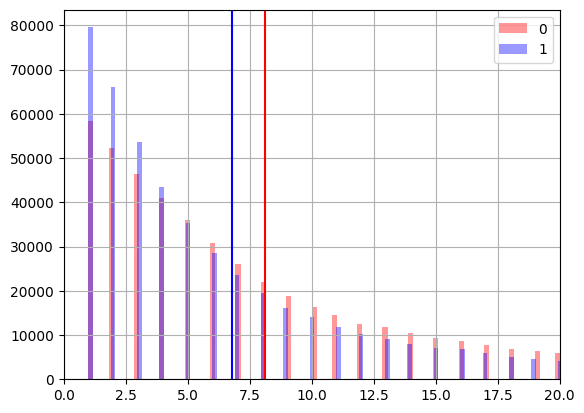

In [30]:
fig,ax = plt.subplots()
colors= ['r', 'b']
for (i, d) in df_1.groupby('high_bias'):
    d['numest'].hist(alpha=0.4, ax=ax, label=i, bins='auto', color=colors[i])
    plt.axvline(d['numest'].mean(),  color=colors[i])
ax.legend()
ax.set_xlim(0,20)
(df_1.groupby("high_bias")['numest']).describe()

,count,mean,std,min,25%,50%,75%,max
high_bias,,,,,,,,
0,479125.0,1.143924,1.616824,-44.84,0.32,0.88,1.74,9.97
1,479125.0,0.982832,1.569532,-9.93,0.22,0.75,1.54,71.66


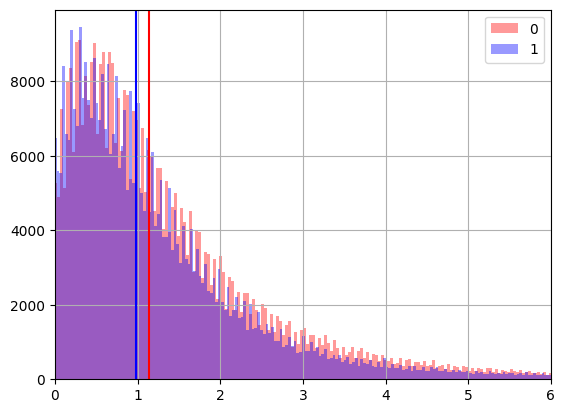

In [31]:
fig,ax = plt.subplots()
colors= ['r', 'b']
for (i, d) in df_1.groupby('high_bias'):
    d['adj_meanest'].hist(alpha=0.4, ax=ax, label=i, bins='auto', color=colors[i])
    plt.axvline(d['adj_meanest'].mean(),  color=colors[i])
ax.legend()
ax.set_xlim(0,6)

(df_1.groupby("high_bias")['adj_meanest']).describe()

,count,mean,std,min,25%,50%,75%,max
high_bias,,,,,,,,
0,479125.0,30.453241,33.760324,0.040,12.500,23.000000,38.770000,2012.709961
1,479125.0,22.565685,26.024292,0.023,8.229,16.200001,28.799999,1926.520020


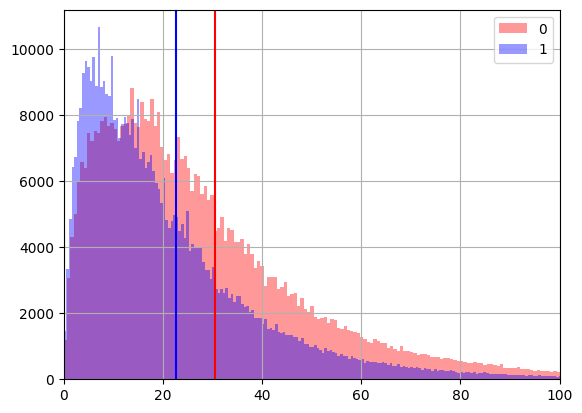

In [32]:
fig,ax = plt.subplots()
colors= ['r', 'b']
for (i, d) in df_1.groupby('high_bias'):
    d['price'].hist(alpha=0.4, ax=ax, label=i, bins='auto', color=colors[i])
    plt.axvline(d['price'].mean(),  color=colors[i])
ax.legend()
ax.set_xlim(0,100)
(df_1.groupby("high_bias")['price']).describe()

,count,mean,std,min,25%,50%,75%,max
high_bias,,,,,,,,
0,479125.0,1.265899,1.653564,-53.05,0.3711,0.96,1.86,44.160
1,479125.0,0.632845,14.544235,-63.00,-0.0133,0.53,1.29,9998.035


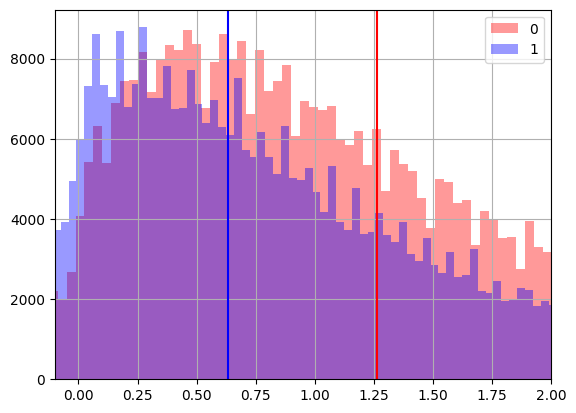

In [33]:
fig,ax = plt.subplots()
colors= ['r', 'b']
for (i, d) in df_1.groupby('high_bias'):
    d['adj_past_eps'].hist(alpha=0.4, ax=ax, label=i, bins='auto', color=colors[i])
    plt.axvline(d['adj_past_eps'].mean(),  color=colors[i])
ax.legend()
ax.set_xlim(-0.1,2)
(df_1.groupby("high_bias")['adj_past_eps']).describe()